In [0]:
import numpy as np

class Multiclass:
    def __init__(self, units=10,batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.batch_size = batch_size

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1  # 첫 번째 층 
        self.a1 = self.sigmoid(z1)
        z2 = np.dot(self.a1, self.w2) +self.b2  # 두 번째 층
        return z2

    def backprop(self, x, error):
        m = len(x)
        # 역방향 진행에 전치행렬곱을 적용
        w2_grad = np.dot(self.a1.T, error) / m
        b2_grad = np.sum(error) / m
        error_to_hidden = np.dot(error, self.w2.T) * self.a1 * (1-self.a1)
        w1_grad = np.dot(x.T, error_to_hidden) / m
        b1_grad = np.sum(error_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)  # 은닉층과 출력층의 가중치를 초기화
        self.init_weight(x.shape[1], y.shape[1])
        m = len(x)
        for i in range(epochs): # 에포크 수 만큼 돌리기
            loss = 0
            print('.', end=' ')
            # 제너레이터에서 반환한 미니배치 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                #y_batch = y_batch.reshape(-1,1)
                #m = len(x_batch)
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.updata_val_loss(x_val, y_val)

    def training(self, x, y):
        # 훈련하는 메서드
        m = len(x)
        z = self.forpass(x)
        a = self.softmax(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)  # 오차 역전파, 그라디언트 계산
        w1_grad += (self.l1*np.sign(self.w1) + self.l2*self.w1)/m
        w2_grad += (self.l1*np.sign(self.w2) + self.l2 * self.w2) / m
        # 절편 업데이트
        self.w1 -= self.lr*w1_grad  # 은닉층, 출력층 가중치 업데이트
        self.w2 -= self.lr*w2_grad
        self.b1 -= self.lr*b1_grad 
        self.b2 -= self.lr*b2_grad
        return a

    def init_weight(self, n_feature, n_classes):
        # 변수를 초기화
        self.w1 = np.random.normal(0,1, (n_feature, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0,1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))  # 인덱스를 섞는다
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]

    def sigmoid(self, z):
        #시그모이드 함수
        a = 1 / (1 + np.exp(-z))
        return a

    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z/ np.sum(exp_z, axis=1).reshape(-1, 1)
    
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환한다.

    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def updata_val_loss(self, x_val, y_val):
        # 검증 손실 계산하기
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a)))
        self.val_losses.append((val_loss + self.reg_loss())/ len(y_val))

    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2/2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [14]:
# MNIST 를 가져와서 분류하기
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


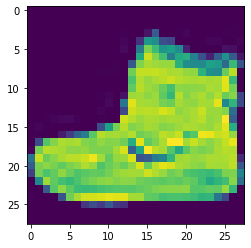

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0])

In [6]:
print(y_train_all[:10])  # MNIST의 각 의미, 0부터 9까지 10 개의 레이블이 있다.

[9 0 0 3 0 2 7 2 5 5]


In [7]:
np.bincount(y_train_all)  # 배열의 정수값을 등장횟수를 세어 정수값에 해당하는 인덱스 위치 저장

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [8]:
# 레이블을 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [0]:
# 입력 데이터 정규화 하기(픽셀 값이 255로 나눠져잇기 때문에)
x_train = x_train / 255
x_val = x_val / 255

# 차원 변경하기 . 28 * 28의 샘플을 784의 길이로 펼치기
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [10]:
# 샘플들을 원-핫-인코딩 하기
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [11]:
# 레이블을 출력해보기
print(y_train[0],y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [26]:
# 다중 분류 신경망 훈련하기
fc = Multiclass(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

0.8150833333333334


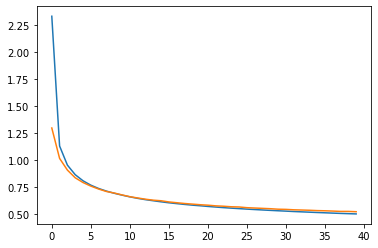

In [27]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)

print(fc.score(x_val, y_val_encoded))

# 텐서플로우와 케라스로 신경망 만들기


In [28]:
# 텐서플로우를 사용하는 경우 간단한 신경망 구현

# 훈련할 가중치 변수 선언 
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이져 사용
optimizer = tf.optimizers.SGD(learning_rate=0.01)  # 학습율 0.01로
# 에포크 설정
epoch = 10
for step in range(epoch):
    with tf.GradientTape() as tape:
        # 자동 미분을 위한 연산과정 기록
        z_net = w * x_train + b
        z_net = tf.reshape(z_net, [-1])
        sqr_error = tf.square(y_train - z_net)
        mean_cost = tf.reduce_mean(sqr_error)
    grads = tape.gradient(mean_cost, [w,b])
    optimizer.apply_gradients(zip(grads, [w,b]))

InvalidArgumentError: ignored

In [29]:
# 케라스 사용
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse')
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 1s 960us/step - loss: nan
Epoch 2/10
1500/1500 [==============================] - 1s 955us/step - loss: nan
Epoch 3/10
1500/1500 [==============================] - 1s 957us/step - loss: nan
Epoch 4/10
1500/1500 [==============================] - 1s 975us/step - loss: nan
Epoch 5/10
1500/1500 [==============================] - 1s 956us/step - loss: nan
Epoch 6/10
1500/1500 [==============================] - 1s 957us/step - loss: nan
Epoch 7/10
1500/1500 [==============================] - 1s 971us/step - loss: nan
Epoch 8/10
1500/1500 [==============================] - 1s 963us/step - loss: nan
Epoch 9/10
1500/1500 [==============================] - 1s 957us/step - loss: nan
Epoch 10/10
1500/1500 [==============================] - 1s 953us/step - loss: nan
